In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import anansescanpy as asc
import os
import numpy as np

work_dir = '../../output'
outputdir=f"{work_dir}/infer/ananse/"
# os.makedirs(outputdir)


In [ ]:

# Fill in the directories where the h5ad RNA and ATAC objects are located
atac_PBMC=sc.read(f'{work_dir}/scATAC/adata_atac.h5ad')
rna_PBMC=sc.read(f'{work_dir}/scRNA/adata_rna.h5ad')

def filter_chr(peaks):
    chrs = [peak.split(':')[0] for peak in peaks]
    mask = np.asarray([True if ('chr' in chr) else False for chr in chrs])
    return mask
    
mask = filter_chr(atac_PBMC.var.index)

atac_PBMC = atac_PBMC[:, mask]

rna_PBMC.obs['cell_type']=rna_PBMC.obs['cell_type'].str.replace(' ', '-').astype('category')
rna_PBMC.obs['cell_type']=rna_PBMC.obs['cell_type'].str.replace('_', '-').astype('category')
atac_PBMC.obs['cell_type']=atac_PBMC.obs['cell_type'].str.replace(' ', '-').astype('category')
atac_PBMC.obs['cell_type']=atac_PBMC.obs['cell_type'].str.replace('_', '-').astype('category')


minimal=25
asc.export_CPM_scANANSE(anndata=rna_PBMC,
min_cells=minimal,
outputdir=outputdir,
cluster_id="cell_type"
)
asc.export_ATAC_scANANSE(anndata=atac_PBMC,
min_cells=minimal,
outputdir=outputdir,
cluster_id="cell_type"
)
asc.config_scANANSE(anndata=rna_PBMC,
min_cells=minimal,
outputdir=outputdir,
cluster_id="cell_type"
)
asc.DEGS_scANANSE(anndata=rna_PBMC,
min_cells=minimal,
outputdir=outputdir,
cluster_id="cell_type"
)

# Process results

In [2]:
df = pd.read_csv(f"{outputdir}/grn/average.tsv", sep='\t')

In [3]:
mask = df.target_expression!=0
df = df[mask].reset_index(drop=True)
df

,tf_target,prob,tf_expression,target_expression,weighted_binding,activity
0,AHR—A1BG,0.771351,0.863296,0.656891,0.862680,0.702539
1,AHR—A1BG-AS1,0.764345,0.863296,0.638495,0.853050,0.702539
2,AHR—A2M,0.704739,0.863296,0.895640,0.357482,0.702539
3,AHR—A2M-AS1,0.694442,0.863296,0.736972,0.474961,0.702539
4,AHR—A2ML1,0.473506,0.863296,0.251416,0.076773,0.702539
...,...,...,...,...,...,...
12185690,ZSCAN31—ZXDC,0.477942,0.204120,0.920270,0.753519,0.033857
12185691,ZSCAN31—ZYG11A,0.185941,0.204120,0.268077,0.237708,0.033857
12185692,ZSCAN31—ZYG11B,0.367832,0.204120,0.838653,0.394697,0.033857
12185693,ZSCAN31—ZYX,0.499372,0.204120,0.837863,0.921650,0.033857


In [4]:
df.set_index('tf_target', inplace=True)

In [5]:
df['weight'] = df.sum(axis=1)

In [5]:
df[['source', 'target']] = df['tf_target'].str.split('—', expand=True)

In [7]:
df = df[['source', 'target', 'prob']] 
df.columns = ['source', 'target', 'weight']

(<Figure size 400x400 with 1 Axes>,
 <Axes: xlabel='Data', ylabel='Cumulative Density'>)

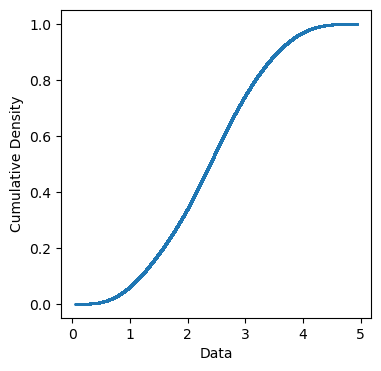

In [6]:
from local_utils import plots
plots.plot_cumulative_density(df.weight)


In [23]:
df_f = df.sort_values('weight').iloc[-50000:,:].reset_index(drop=True)

In [24]:
df_f.target.unique().shape

(2859,)

In [25]:
df_f.to_csv(f"{outputdir}/grn/ananse_grn.csv")